# using data generators



## Fine tuning

In [7]:
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img, img_to_array, to_categorical
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import tensorflow as tf
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import pandas as pd
import datetime
from keras.utils import plot_model
import cv2
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## GPU and version test


In [8]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))
# tensorflow version
print('Tensorflow version:', tf.__version__)

Num GPUs: 1
Tensorflow version: 2.9.2


In [9]:
train_dir = '../datasets/dataset/Train/'
test_dir = '../datasets/dataset/Test'
val2_dir = '../datasets/dataset/Validation'

## Data augmentation


In [10]:
aug_train = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)
aug_test = ImageDataGenerator(
    rescale=1./255,
)


In [11]:
# HyperParameters
TARGET_SIZE = (64, 64)
BATCH_SIZE = 32
CLASS_MODE = 'binary'  # 2 classes (0, 1)
learning_rate = 1e-3
epochs = 15




# Connecting the ImageDataGenerator objects to our dataset
train_generator = aug_train.flow_from_directory(train_dir,
                                                 target_size=TARGET_SIZE,
                                                 subset='training',
                                                 batch_size=BATCH_SIZE,
                                                 class_mode=CLASS_MODE)

validation_generator = aug_train.flow_from_directory(train_dir,
                                                      target_size=TARGET_SIZE,
                                                      subset='validation',
                                                      batch_size=BATCH_SIZE,
                                                      class_mode=CLASS_MODE)
# small test set : 200 images
test_generator = aug_test.flow_from_directory(test_dir,
                                               target_size=TARGET_SIZE,
                                               batch_size=BATCH_SIZE,
                                               class_mode=CLASS_MODE)
# large test set : 11649 images
val2_generator = aug_test.flow_from_directory(val2_dir,
                                               target_size=TARGET_SIZE,
                                               batch_size=BATCH_SIZE,
                                               class_mode=CLASS_MODE)

num_of_train_samples = train_generator.n
num_of_val_samples = validation_generator.n
num_of_test_samples = test_generator.n
print(train_generator.class_indices)

Found 37608 images belonging to 2 classes.
Found 9401 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 11649 images belonging to 2 classes.
{'female': 0, 'male': 1}


In [12]:
# Importing Libraries
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense,Activation,BatchNormalization, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.metrics import FalsePositives,FalseNegatives,BinaryAccuracy,TrueNegatives,TruePositives
import matplotlib.pyplot as plt

In [13]:

# Building CNN Model
model = Sequential()
model.add(Conv2D(32, (5,5), padding='same', activation='relu',
                input_shape=(64, 64, 3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (5,5), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (5,5), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=learning_rate, decay = learning_rate/epochs),
              loss=BinaryCrossentropy(),
              metrics=[BinaryAccuracy(),
                      FalseNegatives(),
                      FalsePositives(),
                          TrueNegatives(),
                            TruePositives(),
                      'accuracy',
])
from ann_visualizer.visualize import ann_viz;

ann_viz(model, title="CNN Model")
model.summary()



Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-01-13 17:20:04.180698: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-13 17:20:04.182074: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
The application cannot be opened for an unexpected reason, error=Error Domain=NSOSStatusErrorDomain Code=-10673 "(null)" UserInfo={_LSLine=4087, _LSFunction=_LSOpenStuffCallLocal}
The application cannot be opened for an unexpected reason, error=Error Domain=NSOSStatusErrorDomain Code=-10673 "(null)" UserInfo={_LSLine=4087, _LSFunction=_LSOpenStuffCallLocal}
The application cannot be opened for an unexpected reason, error=Error Domain=NSOSStatusErrorDomain Code=-10673 "(null)" UserIn

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 64)        0

In [14]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
H = model.fit(train_generator,
        epochs = epochs,
        verbose = 1,
        validation_data = validation_generator,
        # We don't want to save just the weight, but also the model architecture
         callbacks= [ModelCheckpoint('models_jupyter/model_{val_accuracy:.3f}.h5',
                                           save_best_only=True,
                                           save_weights_only=False,
                                           monitor='val_accuracy',
                                             ),tensorboard_callback]
        )

Epoch 1/15


2023-01-13 17:20:24.410343: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-13 17:20:24.841816: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1176/1176 [==============================] - ETA: 0s - loss: 0.3334 - binary_accuracy: 0.8476 - false_negatives: 2825.0000 - false_positives: 2905.0000 - true_negatives: 15690.0000 - true_positives: 16188.0000 - accuracy: 0.8476

2023-01-13 17:21:01.840956: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1176/1176 [==============================] - 46s 38ms/step - loss: 0.3334 - binary_accuracy: 0.8476 - false_negatives: 2825.0000 - false_positives: 2905.0000 - true_negatives: 15690.0000 - true_positives: 16188.0000 - accuracy: 0.8476 - val_loss: 0.2180 - val_binary_accuracy: 0.9233 - val_false_negatives: 406.0000 - val_false_positives: 315.0000 - val_true_negatives: 4333.0000 - val_true_positives: 4347.0000 - val_accuracy: 0.9233
Epoch 2/15
1176/1176 [==============================] - 43s 37ms/step - loss: 0.1916 - binary_accuracy: 0.9278 - false_negatives: 1267.0000 - false_positives: 1448.0000 - true_negatives: 17147.0000 - true_positives: 17746.0000 - accuracy: 0.9278 - val_loss: 0.1496 - val_binary_accuracy: 0.9473 - val_false_negatives: 282.0000 - val_false_positives: 213.0000 - val_true_negatives: 4435.0000 - val_true_positives: 4471.0000 - val_accuracy: 0.9473
Epoch 3/15
1176/1176 [==============================] - 45s 38ms/step - loss: 0.1664 - binary_accuracy: 0.9372 - false_

## Model Loading

In [38]:

model = tf.keras.models.load_model('../models/model_0.968.h5')

# Model Evaluation

In [39]:
from keras.metrics import binary_accuracy
# Getting test accuracy and loss
score = model.evaluate(test_generator)
print(f'Test loss: {score[0]} Test Acc: {score[1]}')



2023-01-12 21:32:36.918734: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 1s 38ms/step - loss: 0.0690 - binary_accuracy: 0.9800 - false_negatives: 2.0000 - false_positives: 2.0000 - true_negatives: 98.0000 - true_positives: 98.0000 - accuracy: 0.9800
Test loss: 0.06904289871454239 Test Acc: 0.9799999594688416


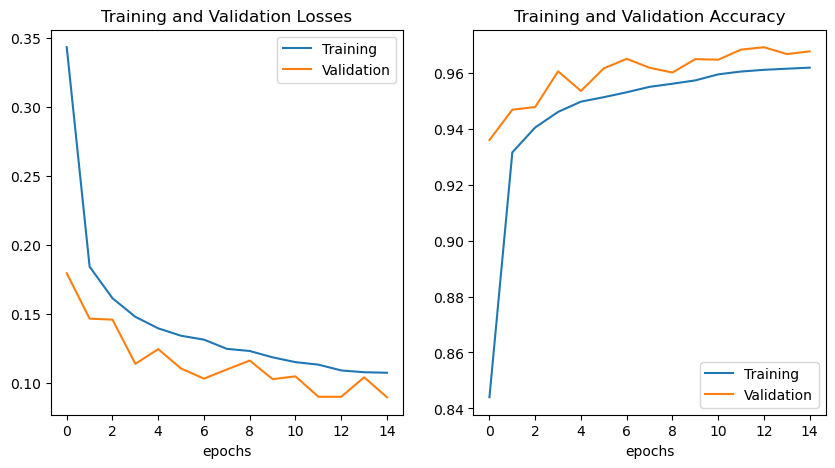

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline
# Plot the model, initialize figure and axes
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Plot training and validation loss
axs[0].plot(H.history['loss'])
axs[0].plot(H.history['val_loss'])
axs[0].legend(['Training', 'Validation'])
axs[0].set_title('Training and Validation Losses')
axs[0].set_xlabel('epochs')

# Plot training and validation accuracy
axs[1].plot(H.history['accuracy'])
axs[1].plot(H.history['val_accuracy'])
axs[1].legend(['Training', 'Validation'])
axs[1].set_title('Training and Validation Accuracy')
axs[1].set_xlabel('epochs')

plt.show()

## Predictions on new test data

In [ ]:

import os

# Set the base path to the 'test' folder
base_path = '../datasets/dataset/Validation'

# Set the paths to the 'male' and 'female' folders
male_path = os.path.join(base_path, 'male')
female_path = os.path.join(base_path, 'female')

# Initialize an empty list to store the images
test_images = []
# Loop through the 'female' folder and append the images to the list
for file_name in os.listdir(female_path):
    file_path = os.path.join(female_path, file_name)
    img = load_img(file_path)
    img = img.resize((64, 64))
    img = img_to_array(img)
    prediction = model.predict(np.array([img]), verbose=0)
    prediction = int(prediction[0][0])
    test_images.append(prediction)
# Loop through the 'male' folder and append the images to the list
for file_name in os.listdir(male_path):
    file_path = os.path.join(male_path, file_name)
    img = load_img(file_path)
    img = img.resize((64, 64))
    img = img_to_array(img)
    prediction = model.predict(np.array([img]), verbose=0)
    prediction = int(prediction[0][0])
    test_images.append(prediction)



    





## Classification report & confusion matrix

              precision    recall  f1-score   support

      female       0.96      0.97      0.97      5841
        male       0.97      0.96      0.97      5808

    accuracy                           0.97     11649
   macro avg       0.97      0.97      0.97     11649
weighted avg       0.97      0.97      0.97     11649



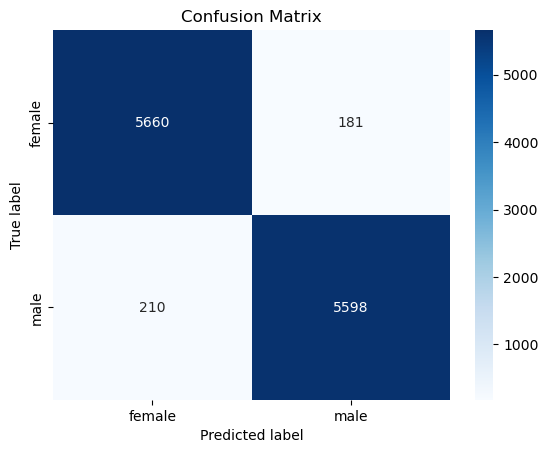

In [16]:
from sklearn.metrics import classification_report,confusion_matrix
# val2_generator = 11649 images
print(classification_report(val2_generator.classes, test_images, target_names=val2_generator.class_indices.keys()))


# Calculate the confusion matrix
confusion_matrix = tf.math.confusion_matrix(val2_generator.classes, test_images).numpy()

# Plot the confusion matrix using seaborn
sns.heatmap(confusion_matrix, annot=True, cmap="Blues", fmt='g',xticklabels=["female", "male"], yticklabels=["female", "male"])
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")
plt.show()

# Single prediction, insert the path of any image that you want


In [4]:
# Making a Single Prediction
import numpy as np
from keras.preprocessing import image



# load and resize image to 200x200
test_image = load_img('../datasets/little_test_dataset/046.jpg',
                            target_size=TARGET_SIZE)

# convert image to numpy array
images = img_to_array(test_image)
# expand dimension of image
images = np.expand_dims(images, axis=0)
# making prediction with model
prediction = model.predict(images)
# print prediction

print(prediction)
if prediction > 0.5:
  print('female')
else:
  print('male')

NameError: name 'TARGET_SIZE' is not defined

# Tensorboard

In [12]:
%tensorboard --logdir 'logs'

Reusing TensorBoard on port 6007 (pid 7764), started 0:17:27 ago. (Use '!kill 7764' to kill it.)

## Model Visualisation


In [4]:
from ann_visualizer.visualize import ann_viz;
import tensorflow as tf
ann_viz(model, title="My first neural network")

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-01-12 00:17:00.833921: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-12 00:17:00.834632: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
